# 🏈 Principal Component Analysis using QB performance

###  Import libraries and define the fonts and colors to use

In [209]:
from sklearn.cluster import KMeans
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib import font_manager as fm

from matplotlib.colors import LinearSegmentedColormap
import os

In [210]:
color_palette = ['#1f77b4',  # Vibrant Teal
                  '#ff9896',  # Orange
                  '#ff7f0e',  # Coral Red
                  '#2ca02c',  # Bright Green
                  '#9467bd'  # Purple
                  ]
fpath = 'C:/USERS/FCO_N/APPDATA/LOCAL/MICROSOFT/WINDOWS/FONTS/RethinkSans-VariableFont_wght.ttf'
prop = fm.FontProperties(fname=fpath)


## Load data

In [211]:
#Data taken from https://www.pro-football-reference.com/years/2023/passing.htm
data_pass_2023 = pd.read_csv('data.csv' )
data_pass_2022 = pd.read_csv('data_2022.csv' )
data_pass_2021 = pd.read_csv('data_2021.csv' )
data_pass_2020 = pd.read_csv('data_2020.csv' )
data_pass_2019 = pd.read_csv('data_2019.csv' )

#Data taken from https://www.pro-football-reference.com/years/2023/running.htm
data_run_2023 = pd.read_csv('data_rushing_2023.csv' )
data_run_2022 = pd.read_csv('data_rushing_2022.csv' )
data_run_2021 = pd.read_csv('data_rushing_2021.csv' )
data_run_2020 = pd.read_csv('data_rushing_2020.csv' )
data_run_2019 = pd.read_csv('data_rushing_2019.csv' )


## Pre-processing

In [212]:

data_pass_2023['Season'] = str(2023)
data_pass_2022['Season'] = str(2022)
data_pass_2021['Season'] = str(2021)
data_pass_2020['Season'] = str(2020)
data_pass_2019['Season'] = str(2019)

data_pass = pd.concat([data_pass_2023,data_pass_2022, data_pass_2021, data_pass_2020, data_pass_2019]) 
data_pass.index = data_pass['Player'] + '_' + data_pass['Season']

#Split QBrec (QB record shown as Wins-Loses-Ties)
data_pass[['Win', 'Loss', 'Tie']] = data_pass['QBrec'].str.split('-', n = 3, expand = True ).fillna('0')
data_pass[['Win', 'Loss', 'Tie']] = data_pass[['Win', 'Loss', 'Tie']].apply(pd.to_numeric)

#Rename Yds.1
data_pass = data_pass.rename(columns= {'Yds.1': 'Yds lost by Sk'})

#Remove variables that we won't need. 
data_pass = data_pass.drop(columns = ['Player', 'Rk', 'Awards','Pos', 'QBrec', 'Tie', 'Team', 'Season'])

#Keep for the analysis records where a QB played at least 6 games during a season and at least 6 pass attempts
data_pass = data_pass.loc[((data_pass['G'] >= 6) & ((data_pass['GS'] > 1) & (data_pass['Att'] >= 10))), :]

#Remove rows with missing values
data_pass = data_pass.dropna()
data_pass.head(3)

,Age,G,GS,Cmp,Att,Cmp%,Yds,TD,TD%,Int,...,QBR,Sk,Yds lost by Sk,Sk%,NY/A,ANY/A,4QC,GWD,Win,Loss
Tua Tagovailoa_2023,25.0,17.0,17.0,388.0,560.0,69.3,4624.0,29.0,5.2,14.0,...,60.8,29.0,171.0,4.92,7.56,7.48,2.0,2.0,11,6
Jared Goff_2023,29.0,17.0,17.0,407.0,605.0,67.3,4575.0,30.0,5.0,12.0,...,60.3,30.0,197.0,4.72,6.89,6.99,2.0,3.0,12,5
Dak Prescott_2023,30.0,17.0,17.0,410.0,590.0,69.5,4516.0,36.0,6.1,9.0,...,72.7,39.0,255.0,6.20,6.77,7.28,2.0,3.0,12,5


In [213]:
data_run_2023['Season'] = str(2023)
data_run_2022['Season'] = str(2022)
data_run_2021['Season'] = str(2021)
data_run_2020['Season'] = str(2020)
data_run_2019['Season'] = str(2019)

data_run = pd.concat([data_run_2023,data_run_2022, data_run_2021, data_run_2020, data_run_2019]) 
# Replace '*' and '+' with an empty string in the column
data_run['Player'] = data_run['Player'].str.replace('*', '', regex=False).str.replace('+', '', regex=False)
data_run.index = data_run['Player'] + '_' + data_run['Season']

data_run = data_run.drop(columns = ['Rk','Player','Pos','-9999','Pos▲', 'Tm', 'G', 'GS', 'Season', 'Age'])
data_run.columns = data_run.columns + ' (Run)' 
data_run.head(3)

,Att (Run),Yds (Run),TD (Run),1D (Run),Succ% (Run),Lng (Run),Y/A (Run),Y/G (Run),Fmb (Run)
Keisean Nixon_2023,1,11,0,1,100.0,11,11.0,0.6,3
Amani Hooker_2023,1,2,0,1,100.0,2,2.0,0.2,0
C.J. Ham_2023,1,7,0,0,100.0,7,7.0,0.4,0


 Join data

In [214]:
data = data_pass.merge(data_run, left_index=True, right_index=True, how ='left')

#Fill nas in running columns as 0
data = data.fillna(0)

display(data.head(3))

,Age,G,GS,Cmp,Att,Cmp%,Yds,TD,TD%,Int,...,Loss,Att (Run),Yds (Run),TD (Run),1D (Run),Succ% (Run),Lng (Run),Y/A (Run),Y/G (Run),Fmb (Run)
Tua Tagovailoa_2023,25.0,17.0,17.0,388.0,560.0,69.3,4624.0,29.0,5.2,14.0,...,6,35,74,0,5,20.0,9,2.1,4.4,13
Jared Goff_2023,29.0,17.0,17.0,407.0,605.0,67.3,4575.0,30.0,5.0,12.0,...,5,32,21,2,5,21.9,11,0.7,1.2,6
Dak Prescott_2023,30.0,17.0,17.0,410.0,590.0,69.5,4516.0,36.0,6.1,9.0,...,5,55,242,2,21,52.7,22,4.4,14.2,4


## Initial PCA

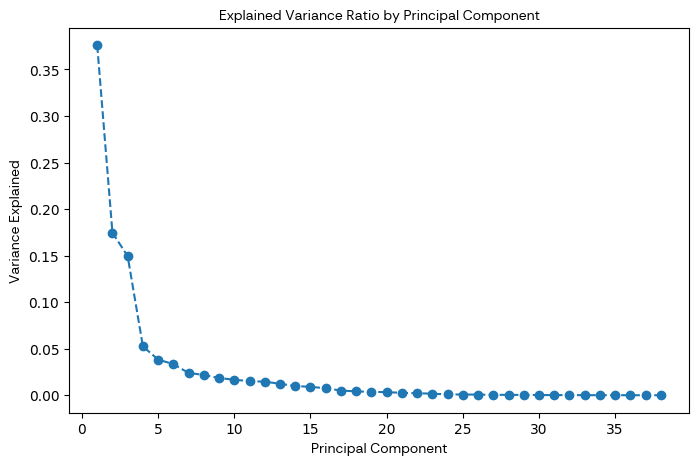

In [215]:
# Standardizing the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply PCA
pca = PCA(random_state= 43, whiten = True)
pca_result = pca.fit_transform(scaled_data)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Principal Component', fontproperties=prop)
plt.xlabel('Principal Component', fontproperties=prop)
plt.ylabel('Variance Explained', fontproperties=prop)
plt.show()

### Initial Biplot

C:\Users\fco_n\AppData\Local\Temp\ipykernel_20864\214898498.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


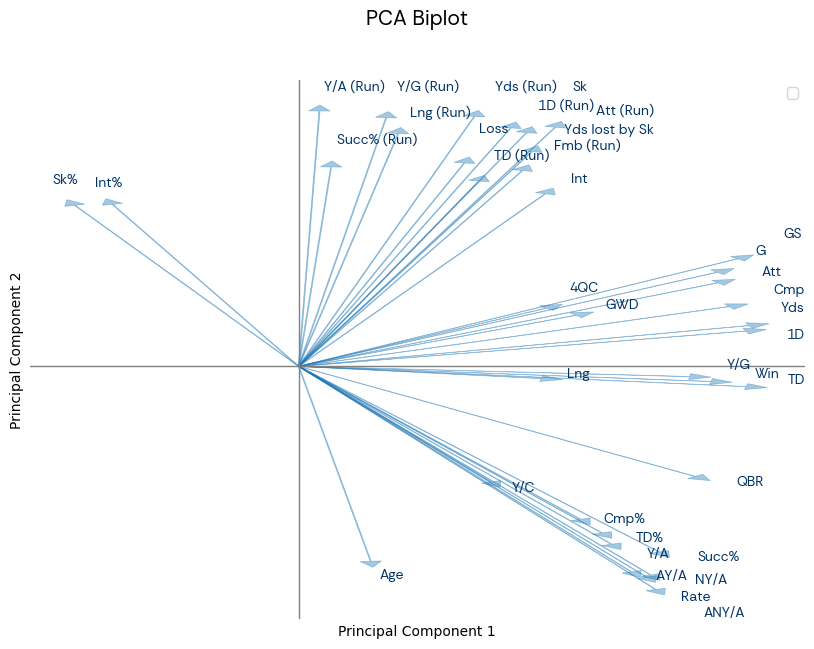

<module 'matplotlib.pyplot' from 'c:\\Users\\fco_n\\Documents\\upwork\\portfolio\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [216]:

def pca_2(scaled_data,data, random = 43):
    pca = PCA(n_components=2, random_state = random, whiten = True)  # Reduce to 2 components for visualization
    pca_result = pca.fit_transform(scaled_data)
    # Create DataFrame for PCA results
    pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
    pca_df.index = data.index

    return [pca_df, pca] 

def print_biplot(pca_df,pca, data, text_dist = 1.1):

    plt.figure(figsize=(10, 7))
    texts = []
    # Add biplot vectors
    for i in range(len(data.columns)):
        plt.arrow(0, 0, pca.components_[0, i] * max(pca_df['PC1']),
                pca.components_[1, i] * max(pca_df['PC2']),
                head_width=0.02, head_length=0.02,  color = color_palette[0], alpha = .4, linewidth = .5)
        text = plt.text(pca.components_[0, i] * max(pca_df['PC1']) * text_dist, 
                pca.components_[1, i] * max(pca_df['PC2']) * text_dist, 
                data.columns[i], color='#003366', fontsize=10 , fontproperties=prop)
        texts.append(text)

    # Adjust text labels to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='-|>', color='white'), alpha = .2)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA Biplot', pad = 40, fontproperties=prop, fontsize = 15)
    ax = plt.gca()
    ax.grid(False)
    ax.axhline(0, color='gray', linewidth=1, linestyle='-')
    ax.axvline(0, color='gray', linewidth=1, linestyle='-')

    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([]) 
    
    for spine in ax.spines.values():
        spine.set_visible(False)
    plt.legend()
    plt.show()

    return plt

pca_df,pca = pca_2(scaled_data,data)
print_biplot(pca_df,pca,data)

### Simplistic Results (showing 2023 data)

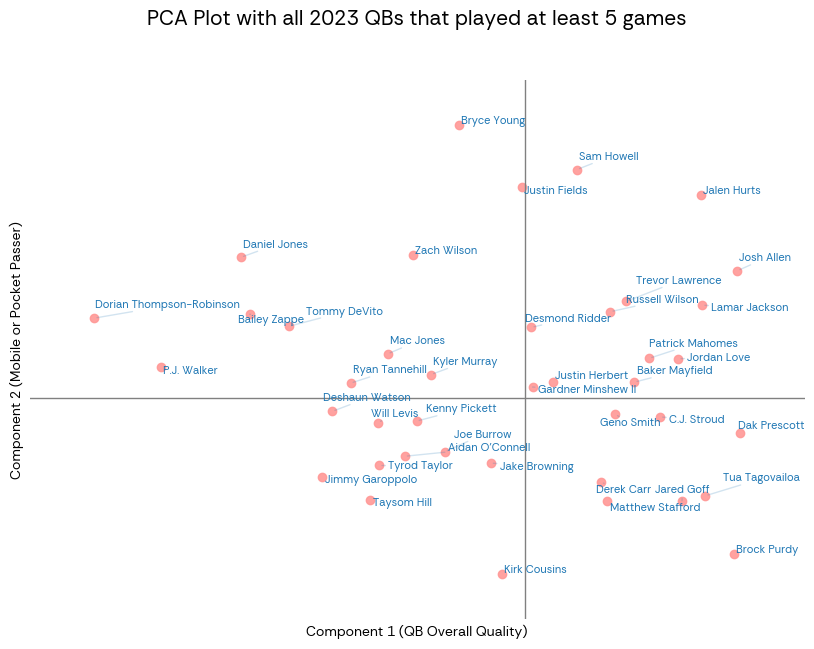

<module 'matplotlib.pyplot' from 'c:\\Users\\fco_n\\Documents\\upwork\\portfolio\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [217]:
def pca_2023(pca_df):
    pca_2023 = pca_df[pca_df.index.str.contains('2023')]
    pca_2023.index = pca_2023.index.str.replace('_2023','')

    # Plot PCA results
    plt.figure(figsize=(10, 7))

    # Adjust the subplot parameters to add more padding
    plt.margins(y = .1, x = .1)

    plt.scatter(pca_2023['PC1'], pca_2023['PC2'], alpha=0.9, color = color_palette[1])

    # Add tags
    indices_to_tag = pca_2023.index

    # Create a list to hold text objects
    texts = []

    for index in indices_to_tag:
        x = pca_2023['PC1'][index]
        y = pca_2023['PC2'][index]
        text = plt.text(x, y, index, color=color_palette[0], fontsize=8, ha='left', fontproperties=prop)
        texts.append(text)

    # Adjust text labels to avoid overlap
    adjust_text(texts, arrowprops=dict(arrowstyle='-', color=color_palette[0]), alpha = .2)

    plt.xlabel('Component 1 (QB Overall Quality)', fontproperties=prop)
    plt.ylabel('Component 2 (Mobile or Pocket Passer)', fontproperties=prop)
    plt.title('PCA Plot with all 2023 QBs that played at least 5 games',pad = 40, fontproperties=prop, fontsize =15)

    ax = plt.gca()
    ax.grid(False)
    ax.axhline(0, color='gray', linewidth=1, linestyle='-')
    ax.axvline(0, color='gray', linewidth=1, linestyle='-')

    ax.set_xticks([])  # Remove x-axis ticks
    ax.set_yticks([]) 
    
    for spine in ax.spines.values():
        spine.set_visible(False)


    plt.show()

    return plt

pca_2023(pca_df)

## Can we do Better?

### New Preprocessing

In [218]:
data_attempt2 = data.copy()

#Divide absolute numbers by games, attempts, completion, etc. 
data_attempt2['Win'] = data_attempt2['Win']/data_attempt2['G']  #Wins avg.
data_attempt2['Loss'] = data_attempt2['Loss']/data_attempt2['G'] # Loss Avg.
data_attempt2['Yds'] = data_attempt2['Yds']/data_attempt2["Att"] #Yards per attempt
data_attempt2['GS'] = data_attempt2['GS']/data_attempt2['G'] # Games started %
data_attempt2['1D'] = data_attempt2['1D']/data_attempt2['Att'] # 1st Downs/Attempts %
data_attempt2["Yds lost per Sk"] = data_attempt2["Yds lost by Sk"]/data_attempt2['Sk']
data_attempt2['Att'] = data_attempt2['Att']/data_attempt2['G']
data_attempt2['Att (Run)'] = data_attempt2['Att (Run)']/data_attempt2['G']
data_attempt2['TD (Run)'] = data_attempt2['TD (Run)']/data_attempt2['G']
data_attempt2['1D (Run)'] = data_attempt2['1D (Run)']/data_attempt2['G']
data_attempt2['Fmb (Run)'] = data_attempt2['Fmb (Run)']/data_attempt2['G']

data_attempt2 = data_attempt2.drop(columns = ['Sk', 'Cmp', 'TD', 'Int', 'Yds', 'Y/A', '4QC','QBR', 'Rate', 'ANY/A', 'AY/A', 'Loss',  'Yds (Run)', 'G', 'GS','Lng (Run)', 'Lng', 'Yds lost by Sk'])
data_attempt2 = data_attempt2.dropna()

display(data_attempt2.head(3))

,Age,Att,Cmp%,TD%,Int%,1D,Succ%,Y/C,Y/G,Sk%,...,GWD,Win,Att (Run),TD (Run),1D (Run),Succ% (Run),Y/A (Run),Y/G (Run),Fmb (Run),Yds lost per Sk
Tua Tagovailoa_2023,25.0,32.941176,69.3,5.2,2.5,0.396429,50.8,11.9,272.0,4.92,...,2.0,0.647059,2.058824,0.000000,0.294118,20.0,2.1,4.4,0.764706,5.896552
Jared Goff_2023,29.0,35.588235,67.3,5.0,2.0,0.375207,50.9,11.2,269.1,4.72,...,3.0,0.705882,1.882353,0.117647,0.294118,21.9,0.7,1.2,0.352941,6.566667
Dak Prescott_2023,30.0,34.705882,69.5,6.1,1.5,0.376271,51.5,11.0,265.6,6.20,...,3.0,0.705882,3.235294,0.117647,1.235294,52.7,4.4,14.2,0.235294,6.538462


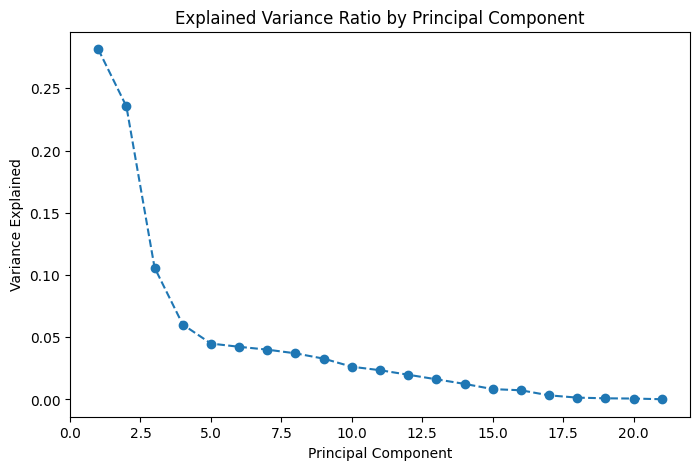

In [219]:
# Standardizing the data
scaler = StandardScaler()
scaled_data1 = scaler.fit_transform(data_attempt2)

# Apply PCA
pca = PCA(random_state= 43, whiten = True)
pca_result = pca.fit_transform(scaled_data1)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance Ratio by Principal Component')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

C:\Users\fco_n\AppData\Local\Temp\ipykernel_20864\214898498.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


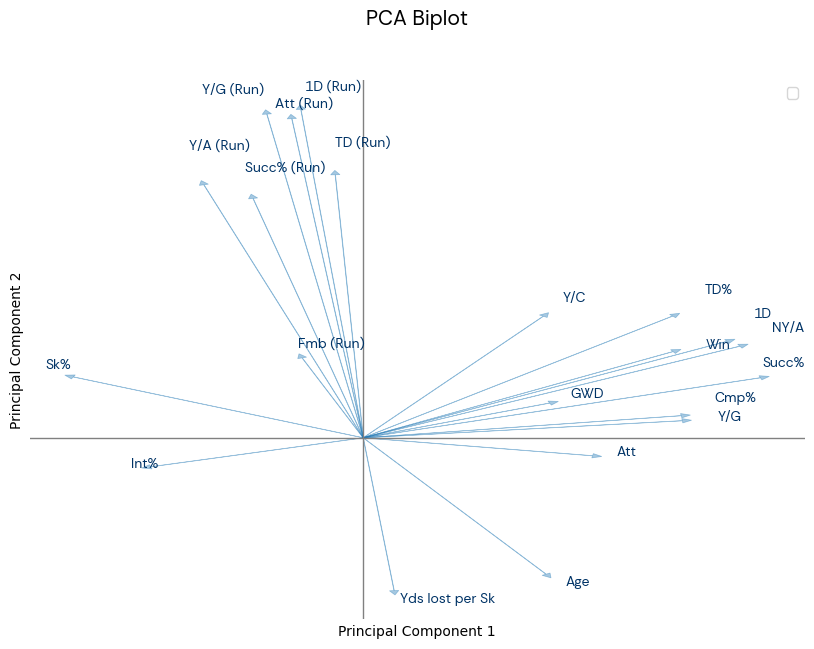

<module 'matplotlib.pyplot' from 'c:\\Users\\fco_n\\Documents\\upwork\\portfolio\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [220]:
pca_df,pca = pca_2(scaled_data1,data_attempt2)
print_biplot(pca_df,pca,data_attempt2)

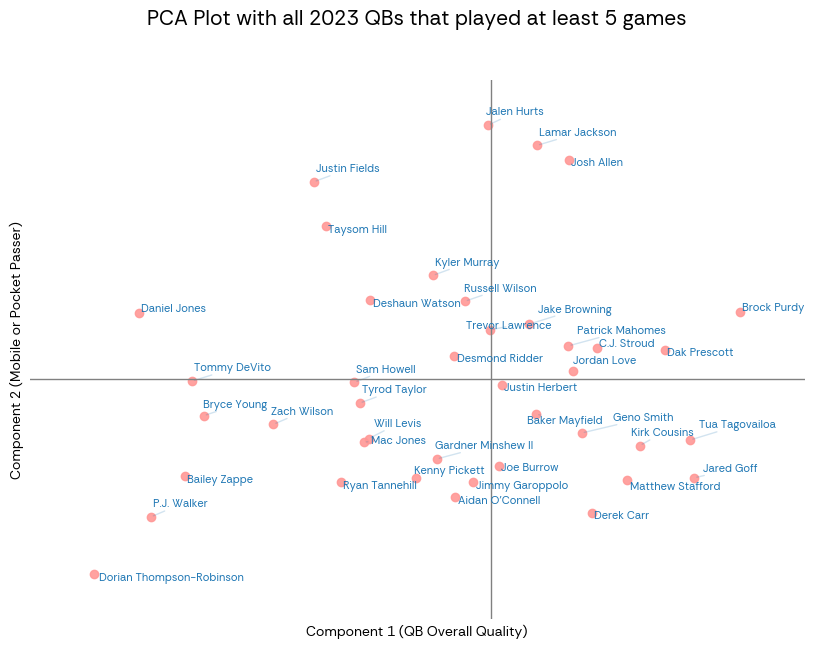

<module 'matplotlib.pyplot' from 'c:\\Users\\fco_n\\Documents\\upwork\\portfolio\\.venv\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [221]:
pca_2023(pca_df)

In [222]:
# Apply K-Means clustering
n_clust = 4

kmeans = KMeans(n_clusters=n_clust,random_state = 23)  # Choose the number of clusters

#Define the pca_df subset
pca_df = pca_df[pca_df.index.str.contains('2023')]
pca_df.index = pca_df.index.str.replace('_2023','')

clusters = kmeans.fit_predict(pca_df)

# Add cluster labels to the DataFrame
pca_df['Cluster'] = clusters

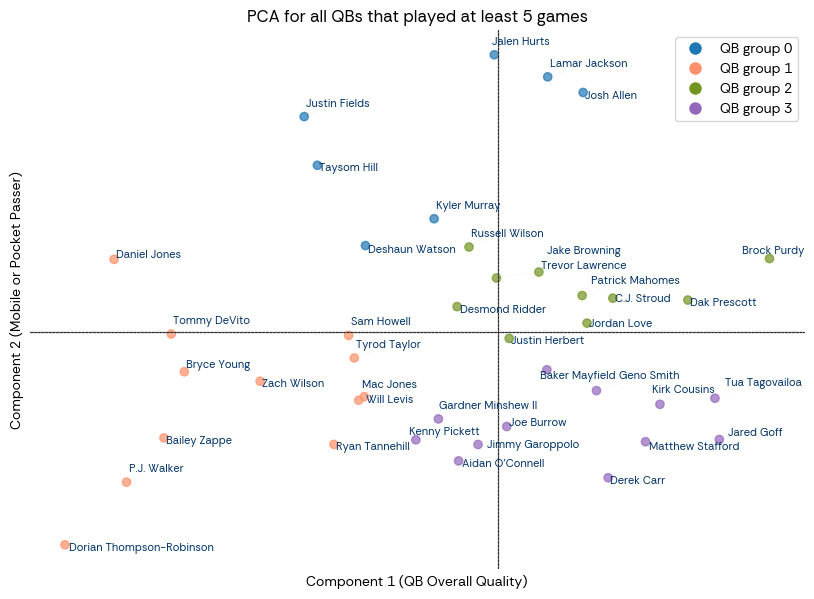

In [223]:

# Define colormap

cmap = LinearSegmentedColormap.from_list('custom_cmap', color_palette)

# Plot PCA results with cluster colors
plt.figure(figsize=(10, 7))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap=cmap, alpha=0.7)

# Add a legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i/(n_clust-1)), markersize=10) for i in range(n_clust)]
plt.legend(handles, [f'QB group {i}' for i in range(n_clust)], title=None, prop = prop)

# Add tags to specific data points
# Specify the indices you want to tag
indices_to_tag = pca_df.index


# Create a list to hold text objects
texts = []

for index in indices_to_tag:
    x = pca_df['PC1'][index]
    y = pca_df['PC2'][index]
    text = plt.text(x, y, str(index), color='#003366', fontsize=8, ha='left', fontproperties=prop)
    texts.append(text)

# Adjust text labels to avoid overlap
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='#4B4B4B'), alpha = .02)

plt.xlabel('Component 1 (QB Overall Quality)', fontproperties=prop)
plt.ylabel('Component 2 (Mobile or Pocket Passer)', fontproperties=prop)
plt.title('PCA for all QBs that played at least 5 games', fontproperties=prop, fontsize =12, fontweight = 'bold')

ax = plt.gca()
ax.grid(False)

ax.axhline(0, color='gray', linewidth=1, linestyle='-')
ax.axvline(0, color='gray', linewidth=1, linestyle='-')

ax.set_xticks([])  # Remove x-axis ticks
ax.set_yticks([]) 

for spine in ax.spines.values():
    spine.set_visible(False)



ax = plt.gca()
ax.grid(False)
ax.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.show()


In [225]:
#Save the data to export it into R
pca_df.to_csv('pca_df.csv')
pca_df.head(5)

,PC1,PC2,Cluster
Tua Tagovailoa,1.238376,-0.527877,3
Jared Goff,1.263605,-0.856974,3
Dak Prescott,1.084063,0.254964,2
Josh Allen,0.486802,1.910643,0
Brock Purdy,1.549643,0.586087,2
